In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Data Preparation & Preprocessing

In [4]:
# Define the target image size and batch size
img_height, img_width = 224, 224
batch_size = 32

# Create an ImageDataGenerator for data augmentation (you can add more parameters if needed)
datagen = ImageDataGenerator(
    rescale=1./255,      # Normalize pixel values
    validation_split=0.2 # Reserve 20% for validation
)

# Directory structure should be like:
# dataset/
#    class1/
#       image1.jpg
#       image2.jpg
#    class2/
#       image1.jpg
#       image2.jpg
#    class3/
#       image1.jpg
#       image2.jpg

train_generator = datagen.flow_from_directory(
    r"D:\images download\New folder\working\Image-Sentiment-Analysis-master\blanced - no natural"
,           # Path to your main dataset folder
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',    # Use 'categorical' if you have more than 2 classes
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    r"D:\images download\New folder\working\Image-Sentiment-Analysis-master\blanced - no natural"
,           # Same folder as above
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 1394 images belonging to 2 classes.
Found 348 images belonging to 2 classes.


In [5]:
# You can print the class indices to see how folders are mapped to labels
print(train_generator.class_indices)

{'neg': 0, 'pos': 1}


In [6]:
import os
from PIL import Image
import hashlib
import matplotlib.pyplot as plt
import numpy as np

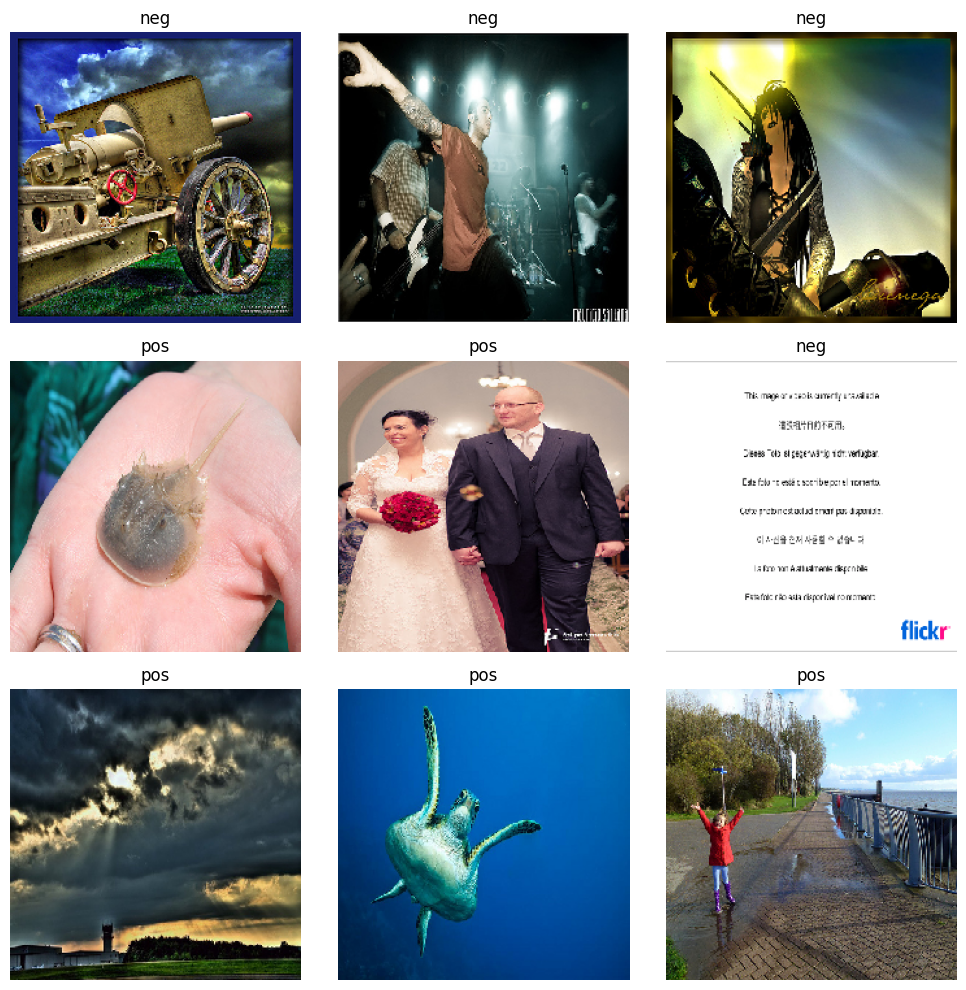

In [7]:


# Get a batch of images and labels
images, labels = next(train_generator)

# Display 9 sample images from the batch
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    # Get the label name by finding the index with max value in one-hot encoded labels
    label_index = np.argmax(labels[i])
    # Map index to class name (train_generator.class_indices is a dict mapping class names to indices)
    class_names = {v: k for k, v in train_generator.class_indices.items()}
    plt.title(class_names[label_index])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [8]:
# Set your dataset directory (adjust the path as needed)
data_dir = r"D:\images download\New folder\working\Image-Sentiment-Analysis-master\\blanced - no natural"

# Dictionaries and lists to store results
hashes = {}
corrupt_files = []
duplicate_between_classes = []
class_distribution = {}

# Walk through each folder in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            file_path = os.path.join(root, file)
            # Assume folder name is the class label
            class_name = os.path.basename(root)
            class_distribution[class_name] = class_distribution.get(class_name, 0) + 1

            try:
                # Open image and verify its integrity
                with Image.open(file_path) as img:
                    img.verify()  # Check for corruption
                # Reopen the image (verify() might leave the file in an unusable state)
                with Image.open(file_path) as img:
                    img = img.convert("RGB")  # Ensure a consistent format
                    # Compute MD5 hash from image data
                    hash_md5 = hashlib.md5(img.tobytes()).hexdigest()
                    
                    if hash_md5 in hashes:
                        # If the image hash exists, check if the classes differ
                        if hashes[hash_md5]['class'] != class_name:
                            duplicate_between_classes.append((file_path, hashes[hash_md5]['file_path']))
                    else:
                        # Store both the file path and class label
                        hashes[hash_md5] = {'class': class_name, 'file_path': file_path}
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
                corrupt_files.append(file_path)

print("Corrupt files found:", corrupt_files)
print("Duplicate images between classes found:")
for dup in duplicate_between_classes:
    print(f"{dup[0]} and {dup[1]}")
print("Class distribution:", class_distribution)

Corrupt files found: []
Duplicate images between classes found:
Class distribution: {'neg': 845, 'pos': 897}


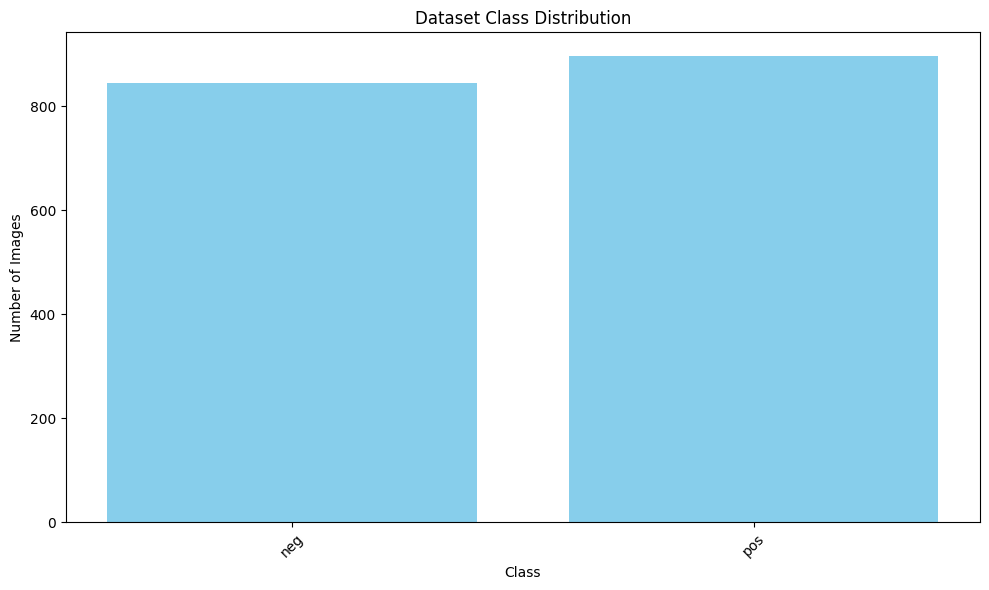

In [9]:
# Plotting class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Dataset Class Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# data augmentation

In [38]:
save_dir= r"D:\images download\New folder\working\Image-Sentiment-Analysis-master\agumented balanced"

In [44]:
# Create a new ImageDataGenerator with the same augmentation parameters.
aug_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

augmented_train_generator = aug_datagen.flow_from_directory(
    r"D:\images download\New folder\working\Image-Sentiment-Analysis-master\blanced - no natural",           # Path to your main dataset folder
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)


# augmented_train_generator = aug_datagen.flow_from_directory(
#     r"D:\images download\New folder\New folder\Image-Sentiment-Analysis-master\images",           # Path to your main dataset folder
#     target_size=(img_height, img_width),
#     batch_size=32,
#     class_mode='categorical',
#     subset='training',
#     save_to_dir=save_dir,          # Directory where augmented images will be saved
#     save_prefix='aug_',          # Prefix for the saved images
#     save_format='jpeg'           # Format for the saved images
# )


# Generate one batch of augmented images to see them saved
images, labels = next(augmented_train_generator)
print("Augmented images have been saved to:", save_dir)


Found 1394 images belonging to 2 classes.
Augmented images have been saved to: D:\images download\New folder\working\Image-Sentiment-Analysis-master\agumented balanced


In [43]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import array_to_img

In [45]:


# Create a mapping from class index to folder name based on train_generator.class_indices
class_mapping = {v: k for k, v in train_generator.class_indices.items()}

# Ensure output directories exist for each class
for class_name in class_mapping.values():
    os.makedirs(os.path.join(save_dir, class_name), exist_ok=True)

# Loop through a few batches and save images into subdirectories based on their labels
num_batches = 10
for i in range(num_batches):
    images, labels = next(augmented_train_generator)
    for j in range(images.shape[0]):
        label_index = np.argmax(labels[j])
        folder = os.path.join(save_dir, class_mapping[label_index])
        # Convert image array back to image and save
        img = array_to_img(images[j])
        img_filename = os.path.join(folder, f"aug_batch{i}_img{j}.jpeg")
        img.save(img_filename)
print("Augmented images have been saved into class subdirectories in:", save_dir)


Augmented images have been saved into class subdirectories in: D:\images download\New folder\working\Image-Sentiment-Analysis-master\agumented balanced


# Model 

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, 
                                     Dropout, GlobalAveragePooling2D, Lambda, Concatenate)
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

In [11]:
# Define the input layer
input_img = Input(shape=(224, 224, 3))

# ------------------------------------------
# CNN Branch for Spatial/Texture Features
# ------------------------------------------
x = Conv2D(32, (3, 3), activation='relu')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# ------------------------------------------
# Color Statistics Branch
# ------------------------------------------
# This branch computes the average value for each color channel.
def compute_color_stats(tensor):
    # Compute the mean across the spatial dimensions
    return K.mean(tensor, axis=[1, 2])

color_features = Lambda(compute_color_stats)(input_img)  # shape (batch, 3)
# Optionally, you can also compute additional statistics like standard deviation

# ------------------------------------------
# Combine Both Branches
# ------------------------------------------
combined = Concatenate()([x, color_features])

# ------------------------------------------
# Final Classification Layers
# ------------------------------------------
output = Dense(2, activation='softmax')(combined)

# Build and compile the model
model = Model(inputs=input_img, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

In [17]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [25]:
model = Sequential([
    Input(shape=(224, 224, 3)),   # Input layer
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Two output classes: negative and positive
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,218 (42.61 MB)

 Trainable params: 11,169,218 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

# Training the Model


In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [27]:
# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True)

In [28]:
# Train the model
history = model.fit(
    train_generator,
    epochs=30,  # You can adjust the number of epochs based on your needs
    validation_data=validation_generator,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5218 - loss: 1.1611

44/44 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.5221 - loss: 1.1539 - val_accuracy: 0.6121 - val_loss: 0.6626
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5881 - loss: 0.6667

44/44 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.5887 - loss: 0.6665 - val_accuracy: 0.7356 - val_loss: 0.5810
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.6555 - loss: 0.6276 - val_accuracy: 0.6494 - val_loss: 0.6129
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.6777 - loss: 0.5932 - val_accuracy: 0.6523 - val_loss: 0.6160
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.7472 - loss: 0.5684 - val_accuracy: 0.6351 - val_loss: 0.7276
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7362 - loss: 0.5066 - val_accuracy: 0.6178 - val_loss: 0.7520
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.7981 - loss: 0.4368 - val_accuracy: 0.6092 - val_loss: 1.0111
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8202 - loss: 0.3662 - val_accuracy: 0.6063 - val_loss: 1.4744


In [29]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 403ms/step
Classification Report:
              precision    recall  f1-score   support

         neg       0.50      0.45      0.47       169
         pos       0.53      0.58      0.55       179

    accuracy                           0.52       348
   macro avg       0.52      0.52      0.51       348
weighted avg       0.52      0.52      0.52       348



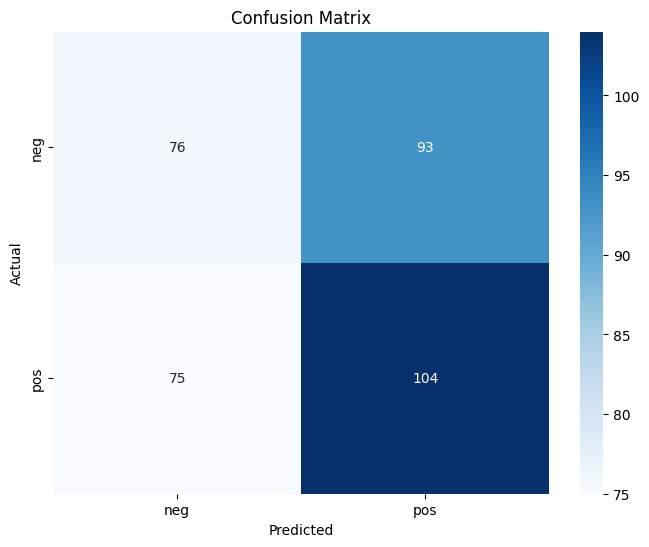

Per-class Accuracy:
neg: 44.97%
pos: 58.10%


In [30]:
# Reset the validation generator to ensure predictions start from the beginning.
validation_generator.reset()

# Predict the classes for the validation set
preds = model.predict(validation_generator, verbose=1)
predicted_classes = np.argmax(preds, axis=1)

# Get the true classes from the generator (they are stored as a flat array of class indices)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Print the classification report (precision, recall, f1-score per class)
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Optionally, compute per-class accuracy to pinpoint the weakest category
per_class_accuracy = {}
for i, label in enumerate(class_labels):
    true_count = np.sum(cm[i, :])
    correct_count = cm[i, i]
    per_class_accuracy[label] = correct_count / true_count if true_count > 0 else 0

print("Per-class Accuracy:")
for label, acc in per_class_accuracy.items():
    print(f"{label}: {acc*100:.2f}%")

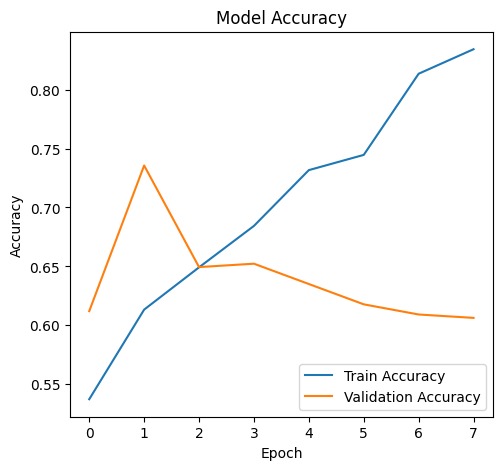

In [31]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

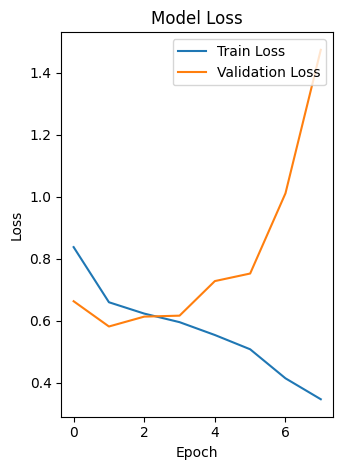

In [32]:
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [33]:
from keras.preprocessing import image


In [34]:
from PIL import Image

In [35]:
# Define the test image directory (update with your actual path)
test_images_path = r"D:\images download\New folder\working\Image-Sentiment-Analysis-master\tested\t2 7x7x7"

# Get a list of image filenames and select 30 images (adjust if needed)
file_names = os.listdir(test_images_path)[:30]

# Initialize list to store images
img_list = []

# Loop through the selected files, load and preprocess each image
for file in file_names:
    img_path = os.path.join(test_images_path, file)
    # Load image with the same target size as used in training (e.g., 224x224)
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array /= 255.0  # Normalize pixel values
    img_list.append(img_array)

In [36]:
# Convert list to numpy array
X_test2 = np.array(img_list)

# Use your trained model to predict classes for these images
predictions2 = model.predict(X_test2)
predicted_classes2 = np.argmax(predictions2, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


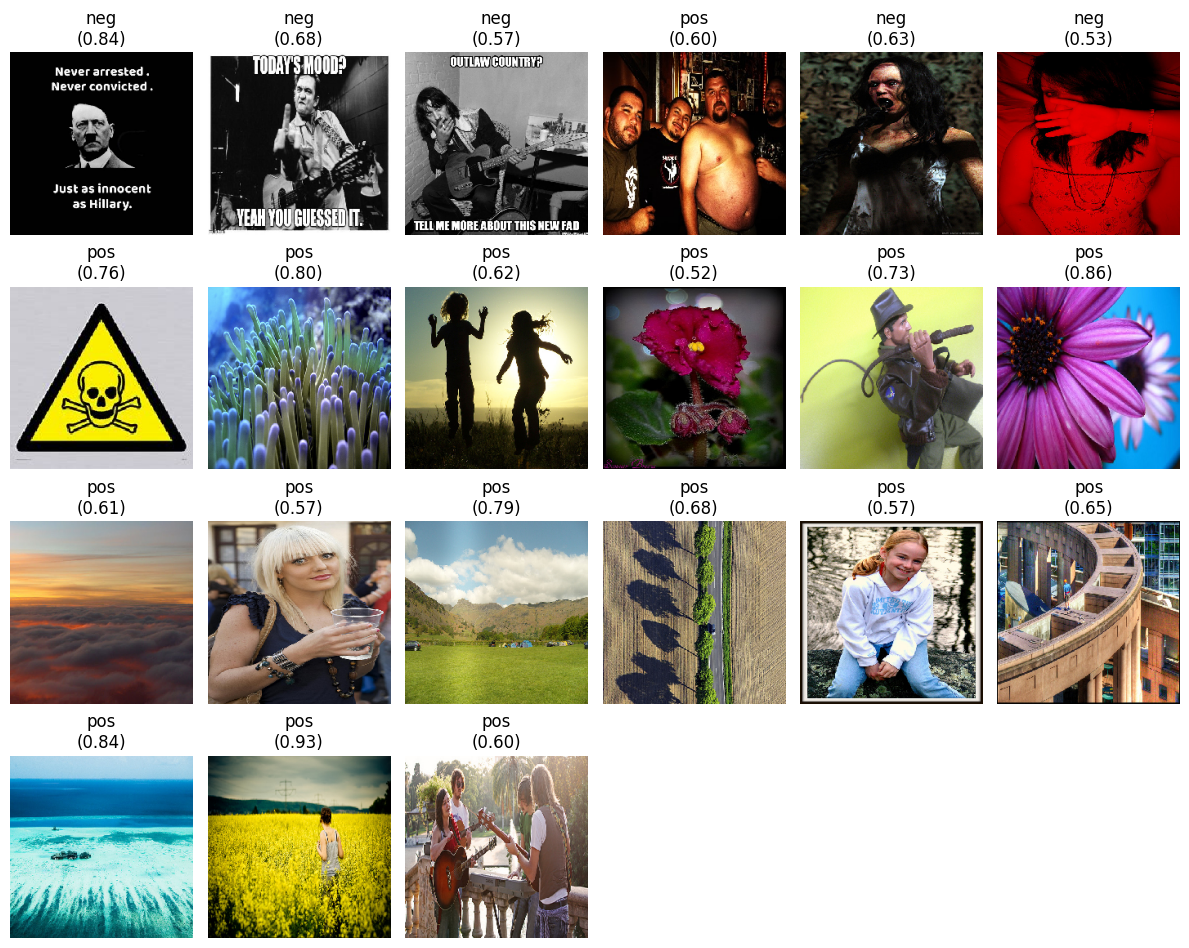

In [46]:
# Optionally, display the images with their predictions
plt.figure(figsize=(12, 12))
for i in range(len(file_names)):
    plt.subplot(5, 6, i + 1)
    plt.imshow(X_test2[i])
    plt.title(f"{class_mapping[predicted_classes2[i]]}\n({predictions2[i][predicted_classes2[i]]:.2f})")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [47]:
# Define the test image directory (update with your actual path)
test_images_path = r"D:\images download\New folder\working\Image-Sentiment-Analysis-master\tested\t1"

# Get a list of image filenames and select 30 images (adjust if needed)
file_names = os.listdir(test_images_path)[:30]

# Initialize list to store images
img_list = []

# Loop through the selected files, load and preprocess each image
for file in file_names:
    img_path = os.path.join(test_images_path, file)
    # Load image with the same target size as used in training (e.g., 224x224)
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array /= 255.0  # Normalize pixel values
    img_list.append(img_array)

In [48]:
# Convert list to numpy array
X_test = np.array(img_list)

# Use your trained model to predict classes for these images
predictions1 = model.predict(X_test)
predicted_classes1 = np.argmax(predictions1, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


In [40]:
# Use your trained model to predict classes for these images
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

NameError: name 'X_test' is not defined

In [50]:
# Invert the mapping from train_generator.class_indices to get class names
class_mapping = {v: k for k, v in train_generator.class_indices.items()}

# Print the predicted classes and confidence for each image
for i, file in enumerate(file_names):
    pred_class = class_mapping[predicted_classes1[i]]
    confidence = predictions1[i][predicted_classes1[i]]
    print(f"Image: {file} -> Predicted: {pred_class} (Confidence: {confidence:.2f})")

Image: neg-0004.jpeg -> Predicted: pos (Confidence: 0.63)
Image: neg-0028.jpeg -> Predicted: neg (Confidence: 0.60)
Image: neg-0058.jpeg -> Predicted: pos (Confidence: 0.60)
Image: neg-0071.jpeg -> Predicted: neg (Confidence: 0.63)
Image: neg-0073.jpeg -> Predicted: pos (Confidence: 0.58)
Image: neg-0133.jpeg -> Predicted: neg (Confidence: 0.63)
Image: neg-0201.jpeg -> Predicted: neg (Confidence: 0.60)
Image: neg-0202.jpeg -> Predicted: neg (Confidence: 0.63)
Image: neg-0254.jpeg -> Predicted: pos (Confidence: 0.55)
Image: neg-0304.jpeg -> Predicted: neg (Confidence: 0.80)
Image: neg-0312.jpeg -> Predicted: pos (Confidence: 0.82)
Image: neg-0313.jpeg -> Predicted: neg (Confidence: 0.80)
Image: neg-0377.jpeg -> Predicted: neg (Confidence: 0.68)
Image: neg-0379.jpeg -> Predicted: pos (Confidence: 0.63)
Image: neg-0383.jpeg -> Predicted: pos (Confidence: 0.50)
Image: neu-0019.jpeg -> Predicted: pos (Confidence: 0.72)
Image: neu-0398.jpeg -> Predicted: pos (Confidence: 0.89)
Image: pos-010

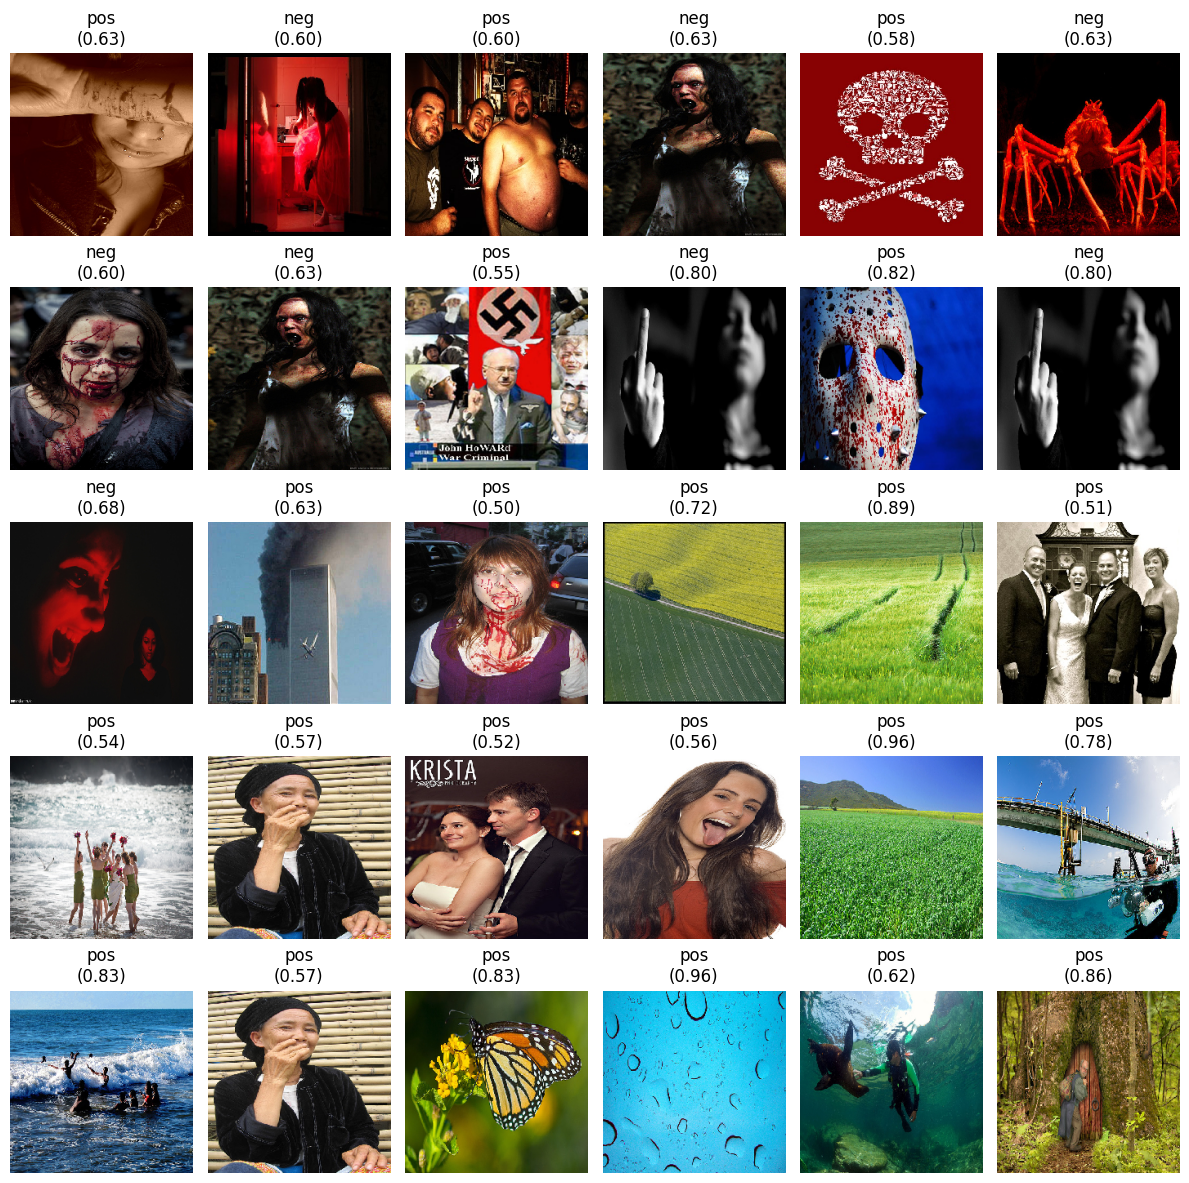

In [53]:
# Optionally, display the images with their predictions
plt.figure(figsize=(12, 12))
for i in range(len(file_names)):
    plt.subplot(5, 6, i + 1)
    plt.imshow(X_test[i])
    plt.title(f"{class_mapping[predicted_classes1[i]]}\n({predictions1[i][predicted_classes1[i]]:.2f})")
    plt.axis("off")
plt.tight_layout()
plt.show()

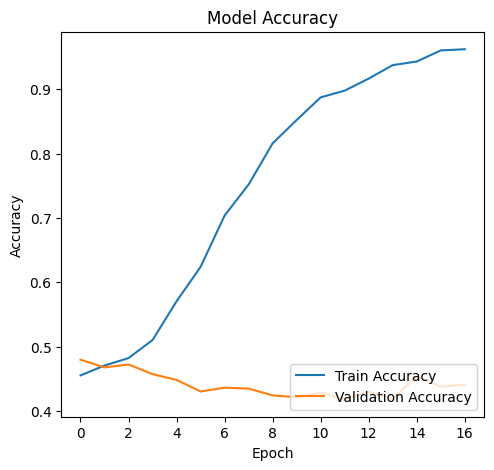

In [46]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

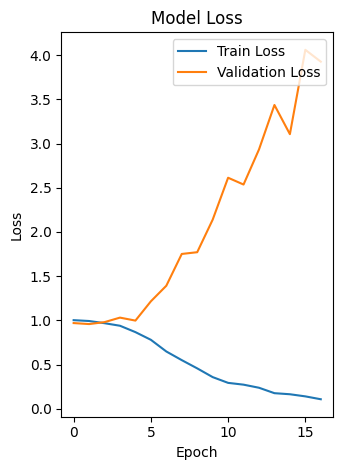

In [47]:
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [48]:
from tensorflow.keras.preprocessing import image

In [49]:
# Define the test image directory (update with your actual path)
test_images_path = r"D:\images download\New folder\New folder\Image-Sentiment-Analysis-master\tested"

# Get a list of image filenames and select 30 images (adjust if needed)
file_names = os.listdir(test_images_path)[:30]

# Initialize list to store images
img_list = []

# Loop through the selected files, load and preprocess each image
for file in file_names:
    img_path = os.path.join(test_images_path, file)
    # Load image with the same target size as used in training (e.g., 224x224)
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array /= 255.0  # Normalize pixel values
    img_list.append(img_array)

In [50]:
# Convert list to numpy array
X_test = np.array(img_list)

# Use your trained model to predict classes for these images
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


In [51]:
# Invert the mapping from train_generator.class_indices to get class names
class_mapping = {v: k for k, v in train_generator.class_indices.items()}

# Print the predicted classes and confidence for each image
for i, file in enumerate(file_names):
    pred_class = class_mapping[predicted_classes[i]]
    confidence = predictions[i][predicted_classes[i]]
    print(f"Image: {file} -> Predicted: {pred_class} (Confidence: {confidence:.2f})")

Image: neg-0004.jpeg -> Predicted: pos (Confidence: 0.46)
Image: neg-0028.jpeg -> Predicted: pos (Confidence: 0.49)
Image: neg-0058.jpeg -> Predicted: pos (Confidence: 0.43)
Image: neg-0071.jpeg -> Predicted: pos (Confidence: 0.39)
Image: neg-0073.jpeg -> Predicted: pos (Confidence: 0.51)
Image: neg-0133.jpeg -> Predicted: pos (Confidence: 0.50)
Image: neg-0201.jpeg -> Predicted: pos (Confidence: 0.42)
Image: neg-0202.jpeg -> Predicted: pos (Confidence: 0.39)
Image: neg-0254.jpeg -> Predicted: pos (Confidence: 0.42)
Image: neg-0304.jpeg -> Predicted: neg (Confidence: 0.52)
Image: neg-0312.jpeg -> Predicted: pos (Confidence: 0.52)
Image: neg-0313.jpeg -> Predicted: neg (Confidence: 0.52)
Image: neg-0377.jpeg -> Predicted: pos (Confidence: 0.44)
Image: neg-0379.jpeg -> Predicted: pos (Confidence: 0.40)
Image: neg-0383.jpeg -> Predicted: pos (Confidence: 0.39)
Image: neu-0019.jpeg -> Predicted: pos (Confidence: 0.52)
Image: neu-0398.jpeg -> Predicted: pos (Confidence: 0.54)
Image: pos-010

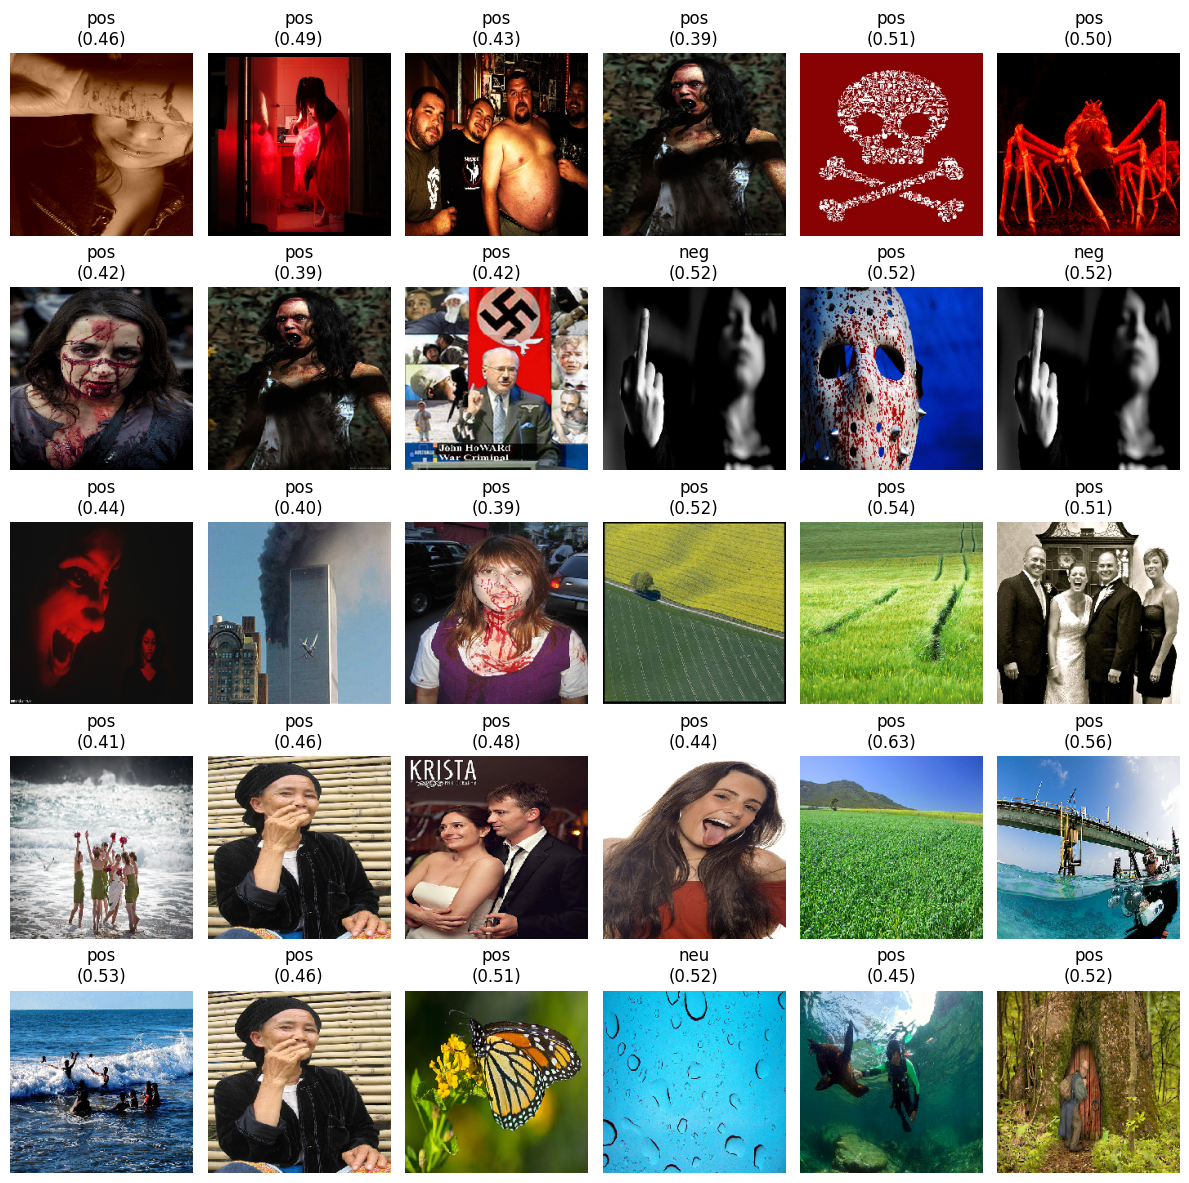

In [52]:
# Optionally, display the images with their predictions
plt.figure(figsize=(12, 12))
for i in range(len(file_names)):
    plt.subplot(5, 6, i + 1)
    plt.imshow(X_test[i])
    plt.title(f"{class_mapping[predicted_classes[i]]}\n({predictions[i][predicted_classes[i]]:.2f})")
    plt.axis("off")
plt.tight_layout()
plt.show()